## Project Introduction

This project is a Django demo app to demonstrate some performance improvements and optimizations, using PostgreSQL as the database.
Its first draft was written along an article blog: [10 tips to Optimize your Django queries with PostgreSQL](https://blog.gitguardian.com/10-tips-to-optimize-postgresql-queries-in-your-django-project/) and was then further improved for [a DjangCon 2023 workshop](https://pretalx.com/djangocon-europe-2023/talk/DK3XET/)

It contains a single app, `books`, with the following models:

- `Library`, either public or private, depending on the number of books it contains.
- `Book`
- `BookTag` for books also available on a specific media, or specific language, in a given library
- `Person`
- `Review`, written by a `Person` on a `Book` from a given `Library`


<br>
<br>
<br>

## Before we start


In [1]:
import os

os.chdir("../..")
import django_init


In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
# For better printing

from rich import print
from rich.console import Console
from rich.markdown import Markdown
from rich.table import Table

console = Console()

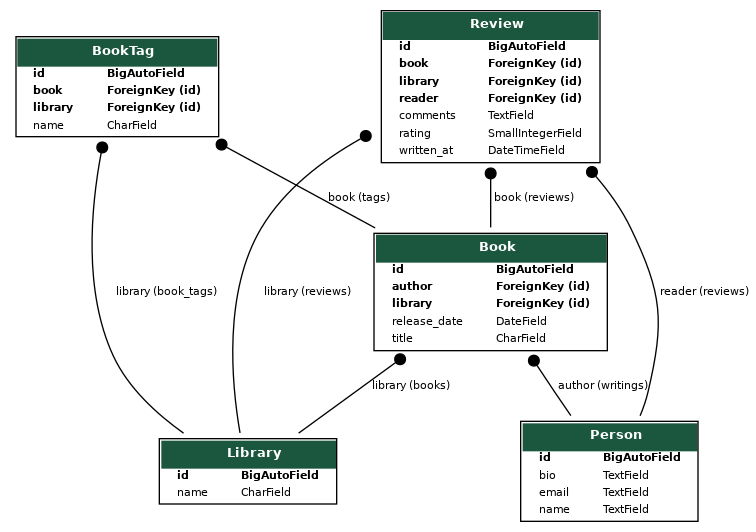

In [4]:
from IPython.core.display import Image
from django.core.management import call_command

call_command("graph_models", "books", output="model_graph.png")
Image("model_graph.png")


In [5]:
from books.models import Book, Library, BookTag, Review, Person

for model in [Library, Person, Book, BookTag, Review]:
    print(f"{model.objects.count():_} {model._meta.verbose_name_plural}")


9_914 libraries

20_100 persons

4_001_000 books

11_998_353 book tags

40_025_291 reviews

---

<br>
<br>

To improve ORM performance, we'll first need a tool to _measure_ queries' execution.

Fortunately, Django offers some basic tools to inspect those queries.

Let's look at them, and define our own contextmanager, [`perf_counter`](../../utils/perf_display.py), to easily record queries


In [6]:
from django.db import connection, reset_queries

reset_queries()
Book.objects.count()
Person.objects.first()
print(connection.queries)
reset_queries()
list(Review.objects.all()[:10])
print(connection.queries)

[
    {'sql': 'SELECT COUNT(*) AS "__count" FROM "books_book"', 'time': '0.278'},
    {
        'sql': 'SELECT "books_person"."id", "books_person"."email", "books_person"."name", "books_person"."bio" 
FROM "books_person" ORDER BY "books_person"."id" ASC LIMIT 1',
        'time': '0.007'
    }
]

[
    {
        'sql': 'SELECT "books_review"."id", "books_review"."book_id", "books_review"."reader_id", 
"books_review"."rating", "books_review"."comments", "books_review"."written_at", "books_review"."library_id" FROM 
"books_review" LIMIT 10',
        'time': '0.001'
    }
]

In [7]:
from utils.perf_display import perf_counter

<br>
<br>
<br>
<br>
<br>
As the `Library` model is the central object in our app, we'll define several ones:
* `Personal`, our personal library, containing around 200 books
* `Public`, a city public library, containing around 20 000 books
* `Alexandria`, the biggest library in our database, containing around 200 000 books


In [8]:
from django.db.models import Count

# Get the library with the most books
library_alexandria_id, book_count = (
    Book.objects.values("library_id")
    .annotate(book_count=Count("id"))
    .order_by("-book_count")
    .values_list("library_id", "book_count")
    .first()
)
# print("Library ID", library_alexandria_id, "book count", book_count)

alexandria = Library.objects.get(id=library_alexandria_id)
alexandria.name = "Alexandria"
alexandria.save()
print("Alexandria has", alexandria.books.count(), "books")

# id not from the 10 libraries with a lot of books
personal = Library.objects.get(id=100)
personal.name = "Personal"
personal.save()
print("Personal has", personal.books.count(), "books")

public = Library.objects.order_by("-id").first()
public.name = "Public"
public.save()
print("Public has", public.books.count(), "books")
public_id = public.id


Alexandria has 200711 books

Personal has 210 books

Public has 20113 books

<br>
<br>

---

## 1st exercice

Let's start with a simple example.
We want to implement, for a given library, a API endpoint returning a JSON object `{book.title: reader_name_list}` for all the books in the library.

A minimal implementation is available in [this file]("../../../../books/views/book/reader_per_book.py).

In this example and the next ones, we'll also use a middle layer between views and models, called `selectors`, to write non-trivial queries.


In [9]:
# Let's try the existing endpoint
from rest_framework.test import APIClient
client = APIClient()
%time result = client.get(f"/books/{personal.id}/readers-per-book")

CPU times: user 476 ms, sys: 52.9 ms, total: 529 ms
Wall time: 1.06 s


In [10]:
print(dict(list(result.json().items())[0:5]))

{
    'Power east modern may tonight reach important west.': [
        'Danny Roberts',
        'Ashley Smith',
        'Scott Chavez',
        'David West',
        'Amanda Nelson',
        'Andrea Soto',
        'Courtney Thomas',
        'Jennifer Sullivan'
    ],
    'Hospital anyone black eye matter ok.': [
        'Alvin Mcbride',
        'Emily Daniels',
        'Shawn Black',
        'Juan Shepard',
        'Lucas Campos',
        'Robin Kennedy',
        'Sarah Cooper',
        'Emily Williams',
        'Autumn Fitzpatrick'
    ],
    'Call usually want fill about senior bank ok.': [
        'Lauren Edwards',
        'Stephen Lopez',
        'Matthew Wheeler',
        'Evelyn Shaw',
        'Julie Rice',
        'Patrick Patel',
        'Fred Jackson',
        'Joseph Olson'
    ],
    'Arrive as middle public paper week Democrat.': [
        'Erik Simmons',
        'Rachel Jackson',
        'Sara Elliott',
        'Michael Prince',
        'Alexandra Diaz',
        'Joann Thomas',
        'Eric Reed',
        'Randall Robinson'
    ],
    'Describe trial check director message accept.': [
        'Stanley Gaines',
        'Sandra Saunders',
        'Mikayla Washington',
        'Carmen Nichols',
        'Vicki Gonzalez',
        'Donna Morse',
        'Melissa Doyle',
        'Jennifer Henderson',
        'Elizabeth Moore',
        'Jeffrey Baker',
        'Tiffany Wiley'
    ]
}

Let's highlight a basic and usual problem with ORMs: the **N+1 query problem**.


In [11]:
reset_queries()


# 1st implementation of list_readers_per_book. Let's use only the first 1000 books
with perf_counter(message="Total execution time", time_sql=True):
    books = Book.objects.filter(library_id=personal.id)
    result = {
        book.title: [reader.name for reader in book.readers.all()] for book in books
    }


print("PostgreSQL queries:")
for query in connection.queries[:4]:
    print(query)
print(
    "Number of queries:",
    len(connection.queries),
    ".",
    "That's the N+1 query problem right here!",
)

Total execution time: 0.91
SQL: 0.46

PostgreSQL queries:

{
    'sql': 'SELECT "books_book"."id", "books_book"."title", "books_book"."author_id", "books_book"."release_date", 
"books_book"."library_id" FROM "books_book" WHERE "books_book"."library_id" = 100',
    'time': '0.002'
}

{
    'sql': 'SELECT "books_person"."id", "books_person"."email", "books_person"."name", "books_person"."bio" FROM 
"books_person" INNER JOIN "books_review" ON ("books_person"."id" = "books_review"."reader_id") WHERE 
"books_review"."book_id" = 2003177',
    'time': '0.001'
}

{
    'sql': 'SELECT "books_person"."id", "books_person"."email", "books_person"."name", "books_person"."bio" FROM 
"books_person" INNER JOIN "books_review" ON ("books_person"."id" = "books_review"."reader_id") WHERE 
"books_review"."book_id" = 2004709',
    'time': '0.001'
}

{
    'sql': 'SELECT "books_person"."id", "books_person"."email", "books_person"."name", "books_person"."bio" FROM 
"books_person" INNER JOIN "books_review" ON ("books_person"."id" = "books_review"."reader_id") WHERE 
"books_review"."book_id" = 2020420',
    'time': '0.002'
}

Number of queries: 211 . That's the N+1 query problem right here!

In [12]:
# Another example, when using a many-to-one relation instead of a one-to-many
reset_queries()

reviews = Review.objects.filter(library_id=public_id)[:100]
results = [
    {"reader": review.reader.name, "book": review.book.title, "rating": review.rating}
    for review in reviews
]

print("Number of queries:", len(connection.queries))

Number of queries: 201

Fortunately, Django offers two methods to solve this problem easily, depending on the side of the relation: [`select_related`](https://docs.djangoproject.com/en/4.2/ref/models/querysets/#select-related) and [`prefetch_related`](https://docs.djangoproject.com/en/4.2/ref/models/querysets/#prefetch-related)


In [13]:
reset_queries()

reviews = Review.objects.select_related("book", "reader").filter(library_id=public_id)[
    :100
]
results = [
    {"reader": review.reader.name, "book": review.book.title, "rating": review.rating}
    for review in reviews
]

print("\nNumber of queries:", len(connection.queries))


Number of queries: 1

In [14]:
# Let's go back to our main example

from django.db import connection, reset_queries

reset_queries()


# 1st implementation of list_readers_per_book.
with perf_counter(message="Total execution time", time_sql=True):
    books = Book.objects.filter(library_id=public_id).prefetch_related("readers")
    result = {
        book.title: [reader.name for reader in book.readers.all()] for book in books
    }

print("PostgreSQL queries:", end="")
for query in connection.queries:
    print("sql:", query["sql"][:1000], "\ntime:", query["time"])

print(
    "Only 2 queries, this is much better! However, the SQL duration is only a fraction of the whole duration"
)


Total execution time: 8.00
SQL: 1.65

PostgreSQL queries:

sql: SELECT "books_book"."id", "books_book"."title", "books_book"."author_id", "books_book"."release_date", 
"books_book"."library_id" FROM "books_book" WHERE "books_book"."library_id" = 10015 
time: 0.041

sql: SELECT ("books_review"."book_id") AS "_prefetch_related_val_book_id", "books_person"."id", 
"books_person"."email", "books_person"."name", "books_person"."bio" FROM "books_person" INNER JOIN "books_review" 
ON ("books_person"."id" = "books_review"."reader_id") WHERE "books_review"."book_id" IN (2369041, 2104245, 2117049,
2118407, 2121977, 2125174, 2125981, 2126569, 2131399, 2131935, 2137050, 2138467, 2139233, 2140007, 2140223, 
2140773, 2141895, 2145889, 2148671, 2150100, 2203534, 2223713, 2390065, 2423498, 2425285, 2744395, 2839918, 
2861693, 2898086, 2912065, 2937578, 2948645, 2950405, 2950872, 2952367, 2955202, 2955607, 2956086, 3025971, 
3045385, 3143965, 3164352, 2005050, 3170755, 3171108, 3175324, 3186276, 3186712, 3189467, 3191488, 3195083, 
3195911, 3204467, 3205361, 3208057, 3214233, 3215093, 3218499, 3219724, 3223322, 3232364, 3282204, 3315104, 
3323399, 3385038, 3385293, 3399919, 3413839, 3460231, 3462122, 3462611, 3466453, 3467135, 3467284, 3469823, 
3470078, 3473145, 3477992, 3481 
time: 1.613

Only 2 queries, this is much better! However, the SQL duration is only a fraction of the whole duration

### Limiting the number of Django-related instantiated objects

When we know what we want to query, and how we want to retrieve, there are better way than using a plain queryset

- `only` queries the specified fields only, wherease `all()` (or any regular queryset) queries them all.

- `values` / `values_list` does not instantiate `models.Model` objects, but only an iterable of `dict` / `tuple`


In [15]:
def retrieve_person_ids(qs, query):
    with perf_counter(message=query, time_sql=True, print_sql=True):
        person_ids = [person.id for person in qs]


retrieve_person_ids(Person.objects.all(), "all()")
retrieve_person_ids(Person.objects.only("id"), 'only("id")')
retrieve_person_ids(
    Person.objects.values_list("id", named=True), 'values_list("id", named=True)'
)


all(): 0.27
SQL: 0.07
       (duration: 0.075)   SELECT "books_person"."id", "books_person"."email", "books_person"."name", 
"books_person"."bio" FROM "books_person"

only("id"): 0.18
SQL: 0.01
       (duration: 0.013)   SELECT "books_person"."id" FROM "books_person"

values_list("id", named=True): 0.03
SQL: 0.01
       (duration: 0.011)   SELECT "books_person"."id" FROM "books_person"

<br>
<br>
<br>

Similarly, There is a trick to avoid instanciating `QuerySet` objects while using `prefetch_related`
We need to use a [`Prefetch` object](https://docs.djangoproject.com/en/4.2/ref/models/querysets/#prefetch-objects) and define `to_attr`


In [16]:
from django.db.models import Prefetch

reset_queries()

qs = Book.objects.filter(library_id=public_id)

prefetch = Prefetch("readers", to_attr="prefetch_readers")
with perf_counter(message="Using 'to_attr'"):
    res = list(qs.prefetch_related(prefetch))

prefetch = Prefetch("readers")
with perf_counter(message="Regular prefetch"):
    res = list(qs.prefetch_related(prefetch))

Using 'to_attr': 7.84

Regular prefetch: 9.27

<br>
<br>
<br>
<br>

Let's apply all these tips to our main example


In [17]:
from django.db.models import Prefetch

# The first implementation using prefetch_related
with perf_counter(message="Previous implementation", time_sql=True):
    books = Book.objects.filter(library_id=public_id).prefetch_related("readers")
    result = {
        book.title: [reader.name for reader in book.readers.all()] for book in books
    }

# The new, improved one
prefetch = Prefetch(
    "readers", queryset=Person.objects.only("name"), to_attr="prefetch_readers"
)
with perf_counter(message="Less Django objects", time_sql=True):
    books = (
        Book.objects.filter(library_id=public_id)
        .only("title")
        .prefetch_related(prefetch)
    )
    result = {
        book.title: [reader.name for reader in book.prefetch_readers] for book in books
    }


Previous implementation: 9.48
SQL: 1.57

Less Django objects: 9.19
SQL: 0.93

<br>
<br>
<br>
<br>

### Beware, prefetch_related is not magic

Most articles on Django ORM will stop here, after showing the available methods in the `QuerySet` API.

That's cool, but not enough.

Even if execution time is fast, the total time (including Django processing and networking) is very long.


In [18]:
with perf_counter("Using a list", time_sql=True, print_sql=True):
    book_ids = Book.objects.filter(library_id=public_id).values_list("id", flat=True)
    # this is basically what prefetch_related_does
    res = list(Review.objects.filter(book_id__in=list(book_ids)).values("id"))

with perf_counter("Using a subquery", time_sql=True, print_sql=True):
    book_ids = Book.objects.filter(library_id=public_id).values_list("id", flat=True)
    # this is basically what prefetch_related_does
    res = list(
        Review.objects.filter(book_id__in=book_ids).values(
            "id", "reader__name", "book__title"
        )
    )

Using a list: 0.90
SQL: 0.45
       (duration: 0.027)   SELECT "books_book"."id" FROM "books_book" WHERE "books_book"."library_id" = 10015
       (duration: 0.419)   SELECT "books_review"."id" FROM "books_review" WHERE "books_review"."book_id" IN 
(2369041, 2104245, 2117049, 2118407, 2121977, 2125174, 2125981, 2126569, 2131399, 2131935, 2137050, 2138467, 
2139233, 2140007, 2140223, 2140773, 2141895, 2145889, 2148671, 2150100, 2203534, 2223713, 2390065, 2423498, 
2425285, 2744395, 2839918, 2861693, 2898086, 2912065, 2937578, 2948645, 2950405, 2950872, 2952367, 2955202, 
2955607, 2956086, 3025971, 3045385, 3143965, 3164352, 2005050, 3170755, 3171108, 3175324, 3186276, 3186712, 
3189467, 3191488, 3195083, 3195911, 3204467, 3205361, 3208057, 3214233, 3215093, 3218499, 3219724, 3223322, 
3232364, 3282204, 3315104, 3323399, 3385038, 3385293, 3399919, 3413839, 3460231, 3462122, 3462611, 3466453, 
3467135, 3467284, 3469823, 3470078, 3473145, 3477992, 3481833, 3482127, 3484164, 3486111, 3486298, 3487902, 
3488038, 3491432, 3492443, 3515316, 3575589, 3583386, 3646286, 3672245, 3684532, 3700536, 3701172, 3709666, 
3710866, 3714210, 3715433, 3723936, 3727299, 3729208,

Using a subquery: 1.54
SQL: 1.10
       (duration: 1.099)   SELECT "books_review"."id", "books_person"."name", "books_book"."title" FROM 
"books_review" INNER JOIN "books_book" ON ("books_review"."book_id" = "books_book"."id") INNER JOIN "books_person" 
ON ("books_review"."reader_id" = "books_person"."id") WHERE "books_review"."book_id" IN (SELECT U0."id" FROM 
"books_book" U0 WHERE U0."library_id" = 10015)

<br>
<br>
<br>
<br>

With `prefetch_related`, we've reduced the number of queries to 2. Is it possible to do a single query?


In [19]:
# Naive method: retrieve all the review objects

from collections import defaultdict

readers_per_book = defaultdict(list)

with perf_counter(message="Regular Django objects", time_sql=True, print_sql=True):
    reviews = Review.objects.filter(library=public_id).select_related("book", "reader")
    for review in reviews:
        readers_per_book[review.book.title].append(review.reader.name)

with perf_counter(message="Tuples", time_sql=True, print_sql=True):
    reviews = Review.objects.filter(library=public_id).values_list(
        "book__title", "reader__name"
    )
    for book_title, reader_name in reviews:
        readers_per_book[book_title].append(reader_name)


Regular Django objects: 21.80
SQL: 5.32
       (duration: 5.320)   SELECT "books_review"."id", "books_review"."book_id", "books_review"."reader_id", 
"books_review"."rating", "books_review"."comments", "books_review"."written_at", "books_review"."library_id", 
"books_book"."id", "books_book"."title", "books_book"."author_id", "books_book"."release_date", 
"books_book"."library_id", "books_person"."id", "books_person"."email", "books_person"."name", "books_person"."bio"
FROM "books_review" INNER JOIN "books_book" ON ("books_review"."book_id" = "books_book"."id") INNER JOIN 
"books_person" ON ("books_review"."reader_id" = "books_person"."id") WHERE "books_review"."library_id" = 10015

Tuples: 3.45
SQL: 2.79
       (duration: 2.794)   SELECT "books_book"."title", "books_person"."name" FROM "books_review" INNER JOIN 
"books_book" ON ("books_review"."book_id" = "books_book"."id") INNER JOIN "books_person" ON 
("books_review"."reader_id" = "books_person"."id") WHERE "books_review"."library_id" = 10015

<br>
<br>
<br>

If only we could get a list directly in PostgreSQL, instead of having to aggregate in python.
Introducing now `django.contrib.postgres.aggregates.ArrayAgg`


In [20]:
from django.contrib.postgres.aggregates import ArrayAgg

with perf_counter(message="LEFT JOINS", time_sql=True, print_sql=True):
    readers_per_book = dict(
        Book.objects.filter(library=public_id)
        .annotate(reader_names=ArrayAgg("readers__name"))
        .values_list("title", "reader_names")
    )

with perf_counter(message="INNER JOINS", time_sql=True, print_sql=True):
    readers_per_book = dict(
        Review.objects.filter(library=public_id)
        .values("book_id")
        .annotate(reader_names=ArrayAgg("reader__name"))
        .values_list("book__title", "reader_names")
    )


LEFT JOINS: 1.21
SQL: 1.05
       (duration: 1.050)   SELECT "books_book"."title", ARRAY_AGG("books_person"."name" ) AS "reader_names" FROM 
"books_book" LEFT OUTER JOIN "books_review" ON ("books_book"."id" = "books_review"."book_id") LEFT OUTER JOIN 
"books_person" ON ("books_review"."reader_id" = "books_person"."id") WHERE "books_book"."library_id" = 10015 GROUP 
BY "books_book"."id"

INNER JOINS: 3.05
SQL: 2.93
       (duration: 2.929)   SELECT "books_book"."title", ARRAY_AGG("books_person"."name" ) AS "reader_names" FROM 
"books_review" INNER JOIN "books_book" ON ("books_review"."book_id" = "books_book"."id") INNER JOIN "books_person" 
ON ("books_review"."reader_id" = "books_person"."id") WHERE "books_review"."library_id" = 10015 GROUP BY 
"books_review"."book_id", "books_book"."title"

We can now go back to the [implementation]("../../../../books/selectors/book/reader_per_book.py) in our code and fix it!


<br>
<br>
<br>
<br>
<br>
<br>

Finally, is this doable for Alexandria?


In [21]:
from rich.table import Table
import time
from utils.perf_display import format_duration

table = Table(show_lines=True)
table.add_column("name", style="bold green")
table.add_column("query")
table.add_column("duration")


def add_row(name, query_str, get_query):
    start = time.perf_counter()
    res = get_query()
    duration = time.perf_counter() - start
    table.add_row(name, query_str, format_duration(duration))


add_row(
    "basic",
    r"""{
    book.title: \[reader.name for reader in book.readers.all()]
    for book in Book.objects.filter(library_id=public_id)
}
""",
    lambda: {
        book.title: [reader.name for reader in book.readers.all()]
        for book in Book.objects.filter(library_id=public_id)
    },
)
add_row(
    "prefetched",
    r"""{
    book.title: \[reader.name for reader in book.readers.all()]
    for book in Book.objects.filter(
        library_id=public_id).prefetch_related("readers")
}
""",
    lambda: {
        book.title: [reader.name for reader in book.readers.all()]
        for book in Book.objects.filter(library_id=public_id).prefetch_related(
            "readers"
        )
    },
)


add_row(
    "prefetched and simplified",
    r"""{
    book.title: \[reader.name for reader in book.prefetch_readers]
    for book in Book.objects.filter(library_id=public_id)
    .only("title")
    .prefetch_related(prefetch)
}
""",
    lambda: {
        book.title: [reader.name for reader in book.prefetch_readers]
        for book in Book.objects.filter(library_id=public_id)
        .only("title")
        .prefetch_related(prefetch)
    },
)


def iterate_over_tuples():
    readers_per_book = defaultdict(list)

    for book_title, reader_name in Review.objects.filter(library=public_id).values_list(
        "book__title", "reader__name"
    ):
        readers_per_book[book_title].append(reader_name)
    return readers_per_book


add_row(
    "iterating over tuples",
    r"""reviews = Review.objects.filter(library=public_id).values_list(
    "book__title", "reader__name"
)
for book_title, reader_name in reviews:
    readers_per_book[book_title].append(reader_name)
""",
    iterate_over_tuples,
)

add_row(
    "ArrayAgg",
    r"""dict(
    Book.objects.filter(library=public_id)
    .annotate(reader_names=ArrayAgg("readers__name"))
    .values_list("title", "reader_names")
)
""",
    lambda: dict(
        Book.objects.filter(library=public_id)
        .annotate(reader_names=ArrayAgg("readers__name"))
        .values_list("title", "reader_names")
    ),
)
console.print(table)


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━┓
┃ name                      ┃ query                                                             ┃ duration ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━┩
│ basic                     │ {                                                                 │ 102.72   │
│                           │     book.title: [reader.name for reader in book.readers.all()]    │          │
│                           │     for book in Book.objects.filter(library_id=public_id)         │          │
│                           │ }                                                                 │          │
│                           │                                                                   │          │
├───────────────────────────┼───────────────────────────────────────────────────────────────────┼──────────┤
│ prefetched                │ {                                                                 │ 9.12     │
│                           │     book.title: [reader.name for reader in book.readers.all()]    │          │
│                           │     for book in Book.objects.filter(                              │          │
│                           │         library_id=public_id).prefetch_related("readers")         │          │
│                           │ }                                                                 │          │
│                           │                                                                   │          │
├───────────────────────────┼───────────────────────────────────────────────────────────────────┼──────────┤
│ prefetched and simplified │ {                                                                 │ 7.35     │
│                           │     book.title: [reader.name for reader in book.prefetch_readers] │          │
│                           │     for book in Book.objects.filter(library_id=public_id)         │          │
│                           │     .only("title")                                                │          │
│                           │     .prefetch_related(prefetch)                                   │          │
│                           │ }                                                                 │          │
│                           │                                                                   │          │
├───────────────────────────┼───────────────────────────────────────────────────────────────────┼──────────┤
│ iterating over tuples     │ reviews = Review.objects.filter(library=public_id).values_list(   │ 3.57     │
│                           │     "book__title", "reader__name"                                 │          │
│                           │ )                                                                 │          │
│                           │ for book_title, reader_name in reviews:                           │          │
│                           │     readers_per_book.append(reader_name)                          │          │
│                           │                                                                   │          │
├───────────────────────────┼───────────────────────────────────────────────────────────────────┼──────────┤
│ ArrayAgg                  │ dict(                                                             │ 1.10     │
│                           │     Book.objects.filter(library=public_id)                        │          │
│                           │     .annotate(reader_names=ArrayAgg("readers__name"))             │          │
│                           │     .values_list("title", "reader_names")                         │          │
│                           │ )                                                                 │          │
│                           │                                               

In [22]:
with perf_counter(time_sql=True, print_sql=True):
    readers_per_book = list(
        Review.objects.filter(library=library_alexandria_id)
        .values("book_id")
        .annotate(reader_names=ArrayAgg("reader__name"))
        .values_list("book__title", "reader_names")
    )


Total time: 25.04
SQL: 22.73
       (duration: 22.727)   SELECT "books_book"."title", ARRAY_AGG("books_person"."name" ) AS "reader_names" FROM 
"books_review" INNER JOIN "books_book" ON ("books_review"."book_id" = "books_book"."id") INNER JOIN "books_person" 
ON ("books_review"."reader_id" = "books_person"."id") WHERE "books_review"."library_id" = 6 GROUP BY 
"books_review"."book_id", "books_book"."title"

Still not really usable...

Fortunately, we'll see yet another optimization, to further improve this, in the next notebooks
